<a href="https://colab.research.google.com/github/allnes/pcam_train/blob/master/pcam_lab_5_train_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%pip install keras-metrics

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd  '/content/drive/My Drive/DL_PCAM'

/content/drive/My Drive/DL_PCAM


In [3]:
import gzip
import shutil
import pandas as pd
from matplotlib import pyplot
import numpy as np
import cv2 as cv
from keras.utils import HDF5Matrix, normalize
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization, Dropout, Activation, Input, ZeroPadding2D, Add

from keras.layers import Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras_metrics as ksm
import tensorflow as tf

Using TensorFlow backend.


In [0]:
train_x_name = 'camelyonpatch_level_2_split_train_x.h5'
train_y_name = 'camelyonpatch_level_2_split_train_y.h5'

test_x_name = 'camelyonpatch_level_2_split_test_x.h5'
test_y_name = 'camelyonpatch_level_2_split_test_y.h5'

valid_x_name = 'camelyonpatch_level_2_split_valid_x.h5'
valid_y_name = 'camelyonpatch_level_2_split_valid_y.h5'

meta_train_name = 'camelyonpatch_level_2_split_train_meta.csv'
meta_valid_name = 'camelyonpatch_level_2_split_valid_meta.csv'
meta_test_name  = 'camelyonpatch_level_2_split_test_meta.csv'

In [0]:
from keras.utils import HDF5Matrix, normalize

x_train = HDF5Matrix(train_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_train = HDF5Matrix(train_y_name, 'y')

x_valid = HDF5Matrix(valid_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_valid = HDF5Matrix(valid_y_name, 'y')

x_test  = HDF5Matrix(test_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_test  = HDF5Matrix(test_y_name, 'y')

262144
<class 'keras.utils.io_utils.HDF5Matrix'>
<class 'numpy.ndarray'>
(96, 96, 3)


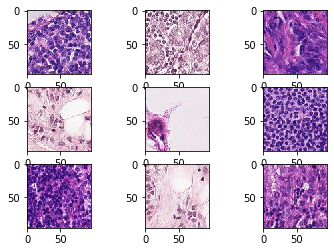

In [6]:
print(len(x_train))
print(type(x_train))
print(type(x_train[0]))
print(x_train[0].shape)

for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()


In [0]:
# Prepare metrics functions
def plot_metrics(code_metrics, name_metrics):
    pyplot.plot(history.history[code_metrics])
    pyplot.plot(history.history['val_' + code_metrics])
    pyplot.title('Model ' + name_metrics)
    pyplot.ylabel(name_metrics)
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Test'], loc='upper left')
    pyplot.show()

def show_metrics(list_metrics, name_stage, name_model):
    name_metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    for i in range(4):
        print(name_model + ' ' + name_stage + ' ' + 
              name_metrics[i] + ' : ' + str(list_metrics[i + 1] * 100))

# Preproc data

In [8]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Reshape
# x_train = np.array(x_train)

y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))

y_valid = np.array(y_valid)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))

print('input share:', input_shape)
print('x_train shape:', x_train.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

input share: (96, 96, 3)
x_train shape: (262144, 96, 96, 3)
262144 train samples
32768 test samples
y_train shape: (262144, 1)


In [9]:
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))
print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

y_valid = np.array(y_valid)
y_valid = y_valid.reshape((y_valid.shape[0], 1))
print("1 in valid : {}".format(np.count_nonzero(y_valid == 1)))
print("0 in valid : {}".format(np.count_nonzero(y_valid == 0)))

1 in train : 131072
0 in train : 131072
1 in valid : 16369
0 in valid : 16399


# Resnet

In [0]:
# Params 
L2_REG = 1e-3       # 1e-4
LEARN_RATE = 1e-3   # 1e-3
BATH_NORM = True    # False

In [0]:
from keras.applications.resnet_v2 import ResNet50V2

def resnetv2_train(input_shape, num_classes=1):
    model_res = ResNet50V2(weights=None, include_top=False, input_shape=input_shape)
    y = Flatten()(model_res.layers[-1].output)
    y = Dense(1, activation='sigmoid', name='fc1', kernel_initializer = 'he_normal')(y)
    model = Model(inputs=model_res.inputs, outputs=y)
    return model

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    # lr = 1e-3
    lr = LEARN_RATE
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

#Compile & run model

In [27]:
model = resnetv2_train(input_shape=input_shape)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics = ['binary_accuracy', 
                         'accuracy',
                          ksm.binary_precision(), 
                          ksm.binary_recall(),
                          ksm.binary_f1_score()
                        ])
# model.summary()

Learning rate:  0.001


In [0]:
import time

BATCH_SIZE = 256
EPOCHS = 10

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [29]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle="batch",
          callbacks=callbacks)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
Learning rate:  0.001
262144/262144 [==============================] - 342s 1ms/step - loss: 0.5127 - binary_accuracy: 0.7798 - acc: 0.7798 - precision: 0.7837 - recall: 0.7727 - f1_score: 0.7782 - val_loss: 0.6946 - val_binary_accuracy: 0.6430 - val_acc: 0.6430 - val_precision: 0.8549 - val_recall: 0.3440 - val_f1_score: 0.4906
Epoch 2/10
Learning rate:  0.001
262144/262144 [==============================] - 333s 1ms/step - loss: 0.4093 - binary_accuracy: 0.8350 - acc: 0.8350 - precision: 0.8378 - recall: 0.8309 - f1_score: 0.8344 - val_loss: 1.6139 - val_binary_accuracy: 0.5021 - val_acc: 0.5021 - val_precision: 0.7313 - val_recall: 0.0060 - val_f1_score: 0.0119
Epoch 3/10
Learning rate:  0.001
262144/262144 [==============================] - 332s 1ms/step - loss: 0.3823 - binary_accuracy: 0.8420 - acc: 0.8420 - precision: 0.8408 - recall: 0.8438 - f1_score: 0.8423 - val_loss: 0.7474 - val_binary_accuracy: 0.6710 - val_acc

# Metrics

In [16]:
prediction = model.predict(x_train)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

print(prediction)

>=0.5 (1): 69324
<0.5 (0): 192820
1 in train : 131072
0 in train : 131072
[[0.1048314 ]
 [0.54920524]
 [0.9772452 ]
 ...
 [0.32467973]
 [0.00134841]
 [0.04591891]]


In [17]:
prediction = model.predict(x_test)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in test : {}".format(np.count_nonzero(y_test == 1)))
print("0 in test : {}".format(np.count_nonzero(y_test == 0)))

print(prediction)

>=0.5 (1): 5266
<0.5 (0): 27502
1 in test : 16377
0 in test : 16391
[[0.00324905]
 [0.00879747]
 [0.0075641 ]
 ...
 [0.00888017]
 [0.03745037]
 [0.00074261]]


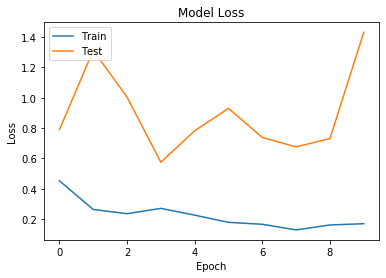

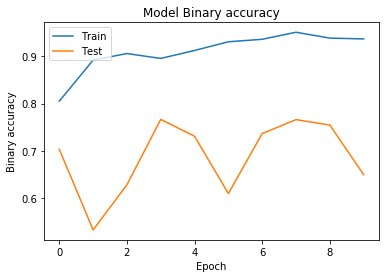

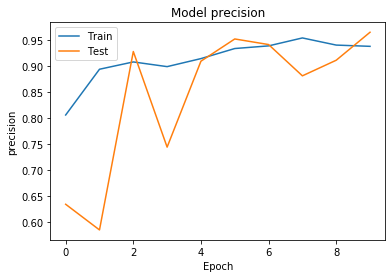

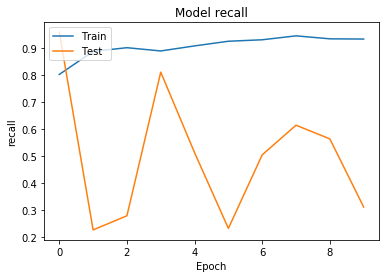

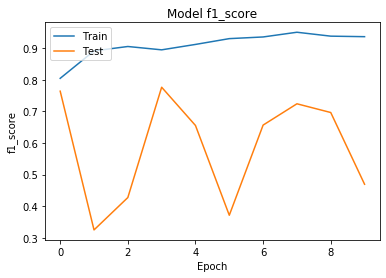

In [18]:
plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Binary accuracy')
plot_metrics('precision', 'precision')
plot_metrics('recall', 'recall')
plot_metrics('f1_score',  'f1_score')

In [19]:
name_model = "resnetv2"
show_metrics(model.evaluate(x_train, y_train), 'train', name_model)
show_metrics(model.evaluate(x_valid, y_valid), 'valid', name_model)
show_metrics(model.evaluate(x_test,  y_test),  'test',  name_model)

262144/262144 [==============================] - 100s 383us/step
mobilenet train accuracy : 75.67520141601562
mobilenet train precision : 75.67520141601562
mobilenet train recall : 98.54451560772813
mobilenet train f1-score : 52.120208740194606
32768/32768 [==============================] - 25s 762us/step
mobilenet valid accuracy : 63.616943359375
mobilenet valid precision : 63.616943359375
mobilenet valid recall : 96.50700690030314
mobilenet valid f1-score : 28.18742745416221
32768/32768 [==============================] - 13s 386us/step
mobilenet test accuracy : 64.9688720703125
mobilenet test precision : 64.9688720703125
mobilenet test recall : 96.50588681928399
mobilenet test f1-score : 31.031324418202168
